**MOTIVATION**

Water is a ubiquitous resource to man, sadly a reasonable amount of water is lost due to various factors including leakages in the water distribution system. This phenomenon presents a very precarious situation for water distribution companies as leaked water otherwise known as non-resource water results in financial losses for any water distribution company. I have decided to present an algorithmic approach to mitigating water leakages.

**THE DATASET**

The dataset used in this project was downloaded open-source from https://marketplace.wessexwater.co.uk/dataset/2nkmn/leakage-acoustic-logger-data. It contains no sensitive information. The data provides useful time-series information returned by leakage detection devices situated in water distribution systems which record valuable real-time.
The dataset contains several excel sheets, but for the purpose of this project we have extracted (columns A to J) from Acoustic logger data, and concatenated it with Columns O to AH – Asset information and GIS-related calculations file.
PROBLEM STATEMENT
Develop an algorithmic approach to detect leakages in water distribution systems using supervised machine learning and predictive analytics.
CONTENT
Data exploration and pre-processing the data including data cleaning, feature engineering, feature extraction by principal component analysis
Employing logistic regression, random forest and artificial neural network classification algorithms to predict water leakages.
Evaluating model performance via significant metrics
Discussion
Limitation and Improvement
The dataset has only input values and no target, however, we can create a binary class label for the purpose of this analysis. The original documentation specifies that the feature Spread which is the difference between the minimum recorded noise and the most frequently occurring noise. It is believed to serve as a measure of consistency. It is believed that the smaller the spread, the less likely for a leak to occur.
On the premise above we discretize the feature Spread by performing a median split, all values smaller than the median value (2.5) are considered a non-leak and assigned a value of 0, while values of spread greater than the median are considered as possible leaks and assigned a value of 1. We then create a new variable called Target to store these binary labels and serve as the target feature during modelling. With this split, we create a dichotomous scenario that typifies a binary classification. We can therefore use supervised machine learning algorithms like logistic regression, Random forest and a neural network to predict Leakages.

In [71]:
# import os module and set os environment 
import os
os.environ['PYTHONHASHSEED']=str(1)

In [72]:
# Importing Libraries and dependencies 
import random
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import tensorflow as tf
from keras import models
from keras import layers
from sklearn import metrics
from keras.layers import Dense
import tensorflow.keras.layers
import matplotlib.pyplot as plt
from keras.layers import Dropout
import tensorflow.keras as keras
from keras.regularizers import l1
warnings.filterwarnings('ignore') 
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [73]:
# set seed for neural network 
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [74]:
data=pd.read_excel('C:\\Users\\Okwua\\Dataset.xlsx', sheet_name=1)

In [75]:
# View dataset 
data.head()

,collect_DA,deploy_DAT,Measure_Da,logger,leakScore,dbMin,Spread,projectNam,measTime,pipeType,...,River_Distance(m),Stream_Distance(m),Railway_Distance(m),A_Road_Distance(m),B_Road_Distance(m),Motorway_Distance(m),Crossroad_Distance(m),Woodland_Distance(m),Footpath_Distance(m),distance_to_control_Valve
0,2019-08-29,2019-08-28,2019-08-29,441580,83,36.5,4.5,WessexZSS04,2019-08-29T02:00:00.000,Distribution Main,...,759.295405,NaN,1380.525792,761.725016,14.483999,32348.475635,43.101512,3355.100471,0.000000,889.507028
1,2019-08-28,2019-08-27,2019-08-28,441620,69,38.5,5.5,WessexZSS04,2019-08-28T02:00:00.000,Distribution Main,...,757.608845,NaN,1377.100527,765.147045,17.524251,32348.813166,42.856556,3358.705672,0.000000,891.781521
2,2019-09-12,2019-09-11,2019-09-12,465031,40,33.0,3.0,WessexZSS09,2019-09-12T02:00:00.000,Distribution Main,...,173.951730,NaN,623.924152,2690.764390,39.240130,19128.969680,1008.942516,731.691114,0.376665,608.369917
3,2019-09-11,2019-09-10,2019-09-11,465040,56,35.5,3.0,WessexZSS09,2019-09-11T02:00:00.000,Distribution Main,...,173.407337,NaN,623.092044,2690.683928,39.772943,19128.057978,1008.866691,732.501136,0.240685,607.385759
4,2019-09-03,2019-08-30,2019-08-31,443015,69,26.0,2.5,WessexZSS03,2019-08-31T02:00:00.000,Distribution Main,...,201.011364,NaN,302.960255,108.894444,178.227383,35949.217064,124.257797,2007.472642,0.000000,1689.925463


## FEATURES AND THEIR MEANING 




**collect_DA**-------	The date that the acoustic logger was collected

**deploy_DAT**-------	The date that the acoustic logger was deployed

**Measure_Da**------	The date that the acoustic logger made its first measurement

**logger**------------	The serial number of the acoustic logger that made the recording

**leakScore**--------	This is the leak score that the logger recorded on the date in column D ("Measure_Da").  

**dbMin**---------------The minimum noise that the logger recorded on the date in column D ("Measure_Da").

**Spread**-----------	This is the difference between the minimum recorded noise and the most frequently occurring noise and is a measure of consistency.  The larger the spread, the less consistent the recorded noise.  If the spread is too small the noise is too consistent to be a leak.

**projectNam**-------	 The ID for the Leakage Technician that deployed the logger

**measTime**----------	 The time at which the acoustic logger made its first measurement

**pipeType**-------------The classification of the pipe at which the logger was deployed

**Diameter**------------ The diameter of the pipe at which the logger was deployed

**Units**--------------  The unit of the diameter

**Date_Laid**------------The date that the pipe was known to be laid

**Age_of_Pipe**--------- The age of the pipe

**Material**-------------The material that the pipe is made of

**Bedrock**--------------The type of bedrock in which the pipe is laid

**WIS Zone**-------------The zone on our supply network in which the logger was deployed

**DMA_Number**---------- A number indicating the specific zone on our supply network in which the logger was deployed. 

**DMA Ref**------------- A reference indicating the specific zone on our supply network in which the logger was deployed

**River_Distance(m)**----The distance to the nearest river

**Stream_Distance(m)**---The distance to the nearest stream

**Railway_Distance(m)**----The distance to the nearest railway

**A_Road_Distance(m)**----The distance to the nearest A-road

**B_Road_Distance(m)**----The distance to the nearest B-Road

**Motorway_Distance(m)**-- The distance to the nearest motorway

**Crossroad_Distance(m)**--The distance to the nearest crossroads

**Woodland_Distance(m)**---The distance to the nearest woodland/forest

**Footpath_Distance(m)**---The distance to the nearest footpath

**distance_to_control_Valve**The distance in metres (down the network pipe) to the nearest control valve.  A control valve creates a restriction in the network and therefore turbulent water; this in turn makes a noise similar to a leak noise.
Note that this column includes pumps and boosters as control valves and sources of noise.



##  DATA EXPLORATION AND PRE-PROCESSING 

In [76]:
print(data.shape)  # Print data dimension 
print('.......................................................................................')
print(data.info())  # Print basic information about the dataset 
print('.......................................................................................')
print(data.isnull().sum())  # Print number of missing values per feature 
print('.......................................................................................')
print(data.describe)   # Print quick statistical summary of the dataset 
print('.......................................................................................')
print(data.duplicated().sum()) # Print sum of duplicate rows in the dataset
print('.......................................................................................')

(230326, 29)
.......................................................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230326 entries, 0 to 230325
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   collect_DA                 230326 non-null  datetime64[ns]
 1   deploy_DAT                 230326 non-null  datetime64[ns]
 2   Measure_Da                 230326 non-null  datetime64[ns]
 3   logger                     230326 non-null  int64         
 4   leakScore                  230326 non-null  int64         
 5   dbMin                      230326 non-null  float64       
 6   Spread                     230326 non-null  float64       
 7   projectNam                 230326 non-null  object        
 8   measTime                   230326 non-null  object        
 9   pipeType                   230326 non-null  object        
 10  Diameter       

In [77]:
## Droping the empty Stream_Distance(m) and projectNam columns because they are empty and contains no useful information repectively  
data.drop(['Stream_Distance(m)','projectNam'], axis=1, inplace=True)

print(data.Age_of_Pipe.isna().sum())  # sum of missing values in Age_of_Pipe feature 

7774


**The Age_of_Pipe feautre contains about 7774 (3.3%) missing values which is not too significant, we would replace the missing values by the mean of the column as the boxplot and distribution plot show a symmetrical distribution of values**


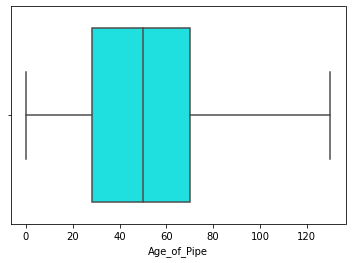

In [78]:
# Visualize boxplot of the Age_of_Pipe feature 
sns.boxplot(data.Age_of_Pipe, color='cyan');

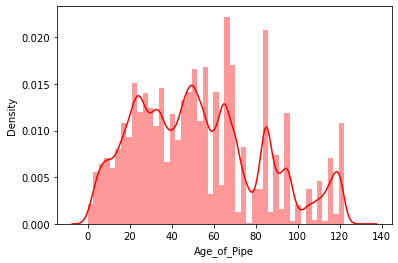

In [79]:
# Visualize distribution plot of the Age_of_Pipe feature 
sns.distplot(data.Age_of_Pipe, color='red');

In [80]:
# replacing missing values in Age_of_Pipe by mean 
data['Age_of_Pipe'] = data['Age_of_Pipe'].fillna(data['Age_of_Pipe'].mean)

# confirming absence of missing values 
data.Age_of_Pipe.isna().sum()

0

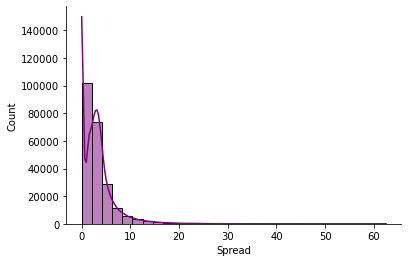

In [81]:
# Visualise Spread feature
sns.histplot(x='Spread', data=data,
            kde=True, bins=30, color='purple')
sns.despine();

In [82]:
#Statistical analysis of Spread variable

mean=data.Spread.mean()
print('The mean of {} is "{}"'.format('Spread', mean))
max_val=data.Spread.max()
print('The maximum value of {} is "{}"'.format('Spread', max_val))
min_val=data.Spread.min()
print('The minimum value of {} is "{}"'.format('Spread', min_val))
Median_val=data.Spread.median()
print('The median of {} is "{}"'.format('Spread', Median_val))

The mean of Spread is "3.136115766348567"
The maximum value of Spread is "62.5"
The minimum value of Spread is "0.0"
The median of Spread is "2.5"


In [83]:
# Create binary class label from the Spread variable as described above

data['Target']=(data['Spread'] > 2.5).astype(int) # call boolean generator to create binary feature 
data.drop('Spread', axis=1, inplace=True)
data.head()

,collect_DA,deploy_DAT,Measure_Da,logger,leakScore,dbMin,measTime,pipeType,Diameter,Units,...,River_Distance(m),Railway_Distance(m),A_Road_Distance(m),B_Road_Distance(m),Motorway_Distance(m),Crossroad_Distance(m),Woodland_Distance(m),Footpath_Distance(m),distance_to_control_Valve,Target
0,2019-08-29,2019-08-28,2019-08-29,441580,83,36.5,2019-08-29T02:00:00.000,Distribution Main,8,In,...,759.295405,1380.525792,761.725016,14.483999,32348.475635,43.101512,3355.100471,0.000000,889.507028,1
1,2019-08-28,2019-08-27,2019-08-28,441620,69,38.5,2019-08-28T02:00:00.000,Distribution Main,8,In,...,757.608845,1377.100527,765.147045,17.524251,32348.813166,42.856556,3358.705672,0.000000,891.781521,1
2,2019-09-12,2019-09-11,2019-09-12,465031,40,33.0,2019-09-12T02:00:00.000,Distribution Main,125,mm,...,173.951730,623.924152,2690.764390,39.240130,19128.969680,1008.942516,731.691114,0.376665,608.369917,1
3,2019-09-11,2019-09-10,2019-09-11,465040,56,35.5,2019-09-11T02:00:00.000,Distribution Main,125,mm,...,173.407337,623.092044,2690.683928,39.772943,19128.057978,1008.866691,732.501136,0.240685,607.385759,1
4,2019-09-03,2019-08-30,2019-08-31,443015,69,26.0,2019-08-31T02:00:00.000,Distribution Main,5,In,...,201.011364,302.960255,108.894444,178.227383,35949.217064,124.257797,2007.472642,0.000000,1689.925463,0


## FEATURE ENGINEERING ##

In [84]:
# Converting datetime columns to useable format 

data['collect_yr']=data['collect_DA'].dt.year
data['collect_month']=data['collect_DA'].dt.month
data['collect_day']=data['collect_DA'].dt.day
data['deploy_yr']=data['deploy_DAT'].dt.year
data['deploy_month']=data['deploy_DAT'].dt.month
data['deploy_day']=data['deploy_DAT'].dt.day
data['Measure_year']=data['Measure_Da'].dt.year
data['Measure_month']=data['Measure_Da'].dt.month
data['Measure_Day']=data['Measure_Da'].dt.day
data['measTime'] = pd.to_datetime(data['measTime'])
data['Date_Laid'] = pd.to_datetime(data['Date_Laid'], errors='coerce')
data['measTime_yr']=data['measTime'].dt.year
data['measTime_month']=data['measTime'].dt.month
data['measTime_day']=data['measTime'].dt.day

data['Date_Laid_yr']=data['Date_Laid'].dt.year
data['Date_Laid_month']=data['Date_Laid'].dt.month
data['Date_Laid_day']=data['Date_Laid'].dt.day

# drop original columns to prevent redundancy during modeling 

data.drop(['collect_DA','deploy_DAT','Measure_Da','measTime','Date_Laid'], axis=1,inplace=True)

# Convert Age_of_Pipe to numeric column 
data['Age_of_Pipe'] = pd.to_numeric(data['Age_of_Pipe'], errors='coerce')

# Dropping all rows with empty values 
data = data.dropna()

In [85]:
data.rename(columns={'WIS Zone': 'WIS_Zone'}, inplace=True)

# displaying unique values in each non-numeric column 

unit_count=data.Units.nunique()
Material_count=data.Material.nunique()
Bedrock_count=data.Bedrock.nunique()
WIS_Zone_count=data.WIS_Zone.nunique()
pipeTy_count=data.pipeType.nunique()

sum_count= unit_count + Material_count + Bedrock_count + WIS_Zone_count + pipeTy_count
print('The total number of unique values in the {} columns is "{}"'.format(' non-numeric', sum_count))

The total number of unique values in the  non-numeric columns is "278"


In [86]:
# dimension of the dataset before encoding categorical features

data.shape

(222552, 37)

In [87]:
# encode categorical features as numeric 
features=['Units','Material','Bedrock','WIS_Zone','pipeType']
data=pd.get_dummies(data,columns=features,drop_first=True)

# dimension of the dataset after encoding categorical features 
data.shape

(222552, 305)

In [88]:
# moving Target variable to the last column position for easier usage

new_cols = [col for col in data.columns if col != 'Target'] + ['Target']
data = data[new_cols]

### FEATURE SCALING ###

In [95]:
# scaling independent variables to fall between 0 and 1(similar to the dependent feature) to prevent favoritism/bias during modelling

X=data.iloc[:,:-1] ## independent features
y=data.iloc[:,-1] ## dependent features

scaler_x=MinMaxScaler()
X_scaled=scaler_x.fit(X)
X_scaled=scaler_x.transform(X)


### DIMENSIONALITY REDUCTION 

In [96]:
pca = PCA(n_components=15)
pca.fit(X_scaled)
x_pca = pca.transform(X_scaled)
print(x_pca.shape)
print(type(x_pca))

(222552, 15)
<class 'numpy.ndarray'>


In [97]:
df_comp = pd.DataFrame(x_pca)
df_comp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.992348,0.045246,0.715221,-0.691812,-0.845578,0.631528,-0.127511,0.074911,-0.112756,0.210472,-0.184099,-0.339915,0.038602,-0.115589,0.066349
1,-0.989915,0.047515,0.649543,-0.691078,-0.835477,0.629718,-0.128710,0.072957,-0.116800,0.211705,-0.184162,-0.341382,0.039963,-0.112869,0.063706
2,1.091464,0.279867,-0.414714,-0.331170,-1.010045,-0.132347,-0.101860,0.049496,0.095014,-0.229636,-0.733243,0.043971,-0.083422,0.937500,-0.125901
3,1.087492,0.280665,-0.480496,-0.336775,-1.003292,-0.134204,-0.100861,0.046687,0.098618,-0.238115,-0.729852,0.053562,-0.081473,0.928651,-0.122502
4,-0.983346,0.101670,0.397318,-0.628402,-0.813155,0.491732,-0.121830,0.124720,-0.158163,0.203059,-0.309333,-0.076503,0.086337,-0.098709,0.041573


### MODELLING

In [98]:
X_train,X_test,y_train,y_test=train_test_split(x_pca,y,test_size=0.2, random_state=1)

In [99]:
#Fitting the model 
log=LogisticRegression( )
log.fit(X_train,y_train)

LogisticRegression()

In [100]:
#Evaluation matrix
ypred=log.predict(X_test)
print(confusion_matrix(y_test,ypred))
print(accuracy_score(y_test,ypred))
print(classification_report(y_test,ypred))

[[16226  7279]
 [12159  8847]]
0.563298959807688
              precision    recall  f1-score   support

           0       0.57      0.69      0.63     23505
           1       0.55      0.42      0.48     21006

    accuracy                           0.56     44511
   macro avg       0.56      0.56      0.55     44511
weighted avg       0.56      0.56      0.56     44511



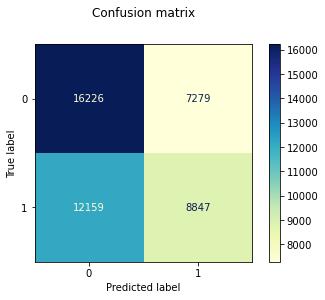

In [101]:
plot_confusion_matrix(log, X_test, y_test, values_format = '',cmap="YlGnBu")
plt.title('Confusion matrix', y=1.1);

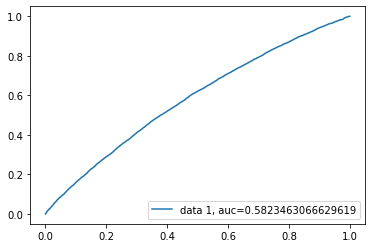

In [102]:
y_pred_proba = log.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### RANDOM FOREST CLASSIFIER

In [103]:
cl=RandomForestClassifier().fit(X_train,y_train)

ypred=cl.predict(X_test)
print(confusion_matrix(y_test,ypred))
print(accuracy_score(y_test,ypred))
print(classification_report(y_test,ypred))

[[16122  7383]
 [ 8026 12980]]
0.653815910673766
              precision    recall  f1-score   support

           0       0.67      0.69      0.68     23505
           1       0.64      0.62      0.63     21006

    accuracy                           0.65     44511
   macro avg       0.65      0.65      0.65     44511
weighted avg       0.65      0.65      0.65     44511



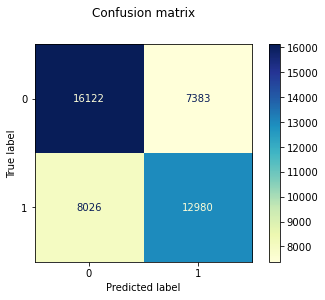

In [104]:
plot_confusion_matrix(cl, X_test, y_test, values_format = '',cmap="YlGnBu")
plt.title('Confusion matrix', y=1.1);

### ARTIFICIAL NEURAL NETWORK

In [107]:
reset_random_seeds() # reset the random seed

ANN_cl = models.Sequential()

#ANN_cl.add(layers.Dense(180, input_shape=(15,), activation='relu', kernel_regularizer=l1(0.01),bias_regularizer=l1(0.01)))
ANN_cl.add(layers.Dense(180, input_shape=(15,), activation='relu'))
# ANN_cl.add(Dropout(0.1))

#ANN_cl.add(layers.Dense(360, activation='relu'))
#ANN_cl.add(layers.Dense(360, activation='relu'))
ANN_cl.add(layers.Dense(180, activation='relu'))
#ANN_cl.add(layers.Dense(90, activation='relu'))
ANN_cl.add(layers.Dense(60, activation='relu'))

ANN_cl.add(layers.Dense(1, activation='sigmoid'))

In [108]:
ANN_cl.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [109]:
history_ANN_cl = ANN_cl.fit(X_train, y_train,
                                validation_data=(X_test, y_test), 
                                epochs=1000, batch_size=200,
                                verbose=2)

Epoch 1/1000
891/891 - 4s - loss: 0.6743 - accuracy: 0.5800 - val_loss: 0.6698 - val_accuracy: 0.5894
Epoch 2/1000
891/891 - 3s - loss: 0.6663 - accuracy: 0.5949 - val_loss: 0.6639 - val_accuracy: 0.5985
Epoch 3/1000
891/891 - 3s - loss: 0.6623 - accuracy: 0.6006 - val_loss: 0.6594 - val_accuracy: 0.6060
Epoch 4/1000
891/891 - 3s - loss: 0.6594 - accuracy: 0.6033 - val_loss: 0.6579 - val_accuracy: 0.6046
Epoch 5/1000
891/891 - 3s - loss: 0.6562 - accuracy: 0.6093 - val_loss: 0.6568 - val_accuracy: 0.6050
Epoch 6/1000
891/891 - 3s - loss: 0.6538 - accuracy: 0.6122 - val_loss: 0.6534 - val_accuracy: 0.6107
Epoch 7/1000
891/891 - 3s - loss: 0.6512 - accuracy: 0.6161 - val_loss: 0.6530 - val_accuracy: 0.6129
Epoch 8/1000
891/891 - 3s - loss: 0.6492 - accuracy: 0.6181 - val_loss: 0.6534 - val_accuracy: 0.6119
Epoch 9/1000
891/891 - 3s - loss: 0.6467 - accuracy: 0.6221 - val_loss: 0.6504 - val_accuracy: 0.6167
Epoch 10/1000
891/891 - 3s - loss: 0.6448 - accuracy: 0.6259 - val_loss: 0.6502 - 

In [121]:
score=ANN_cl.evaluate(X_test,y_test)
Accuracy=score[1]*100
print(Accuracy)

1391/1391 [==============================] - 1s 696us/step - loss: 0.7697 - accuracy: 0.6460
64.59527015686035


### DISCUSSIONS

In this project, I have presented an algorithmic approach to leakage detection in a water distribution system using machine learning and deep learning. I have implemented three models logistic regression, random forest and a neural network with 56%, 65%, 65% accuracy scores respectively. This can be deployed to detect leakages using streaming(real-time)data generated by sensors and transmitted via the cloud services to the company's database. which could significantly reduce the number of leakages encountered in water distribution systems, and therefore save cost.

This is important as leakage detection is a major problem in the water distribution industry.

### LIMITATIONS AND IMPROVEMENT ##

The Ideal leakage detection algorithm should be able to detect all leakages based on streaming data with few false positives, and the detection should be preventive i.e before it becomes visible to humans. The major limitation encountered in this project is data availability- the presence of open-source data relating to historic leakages is almost non-existent due to confidentiality reasons as a dataset of such nature usually contain sensitive customer information.

The dataset used for this experiment contains no direct records for leakages, I have created a target column based on the assumption that the Spread is directly proportional to leakage occurrence as stated above. The median split is not the most intuitive as it assumes that values just above and below the median are only slightly dissimilar which may have prevented the achievement of higher accuracy values. To achieve a more reliable result, we would have to retrain the models with actual historical data.  

Possible improvements would be performing hyperparameter optimisation of these models to determine the optimum input parameters for training the model. 